In [1]:
import scipy

import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Classifier evaluation functions from unit 2

In [2]:
# Build your confusion matrix and calculate sensitivity and specificity here.

def evaluate(y_pred, target):
    conf_data = {'target':target, 'y_pred':y_pred}
    conf_data = pd.DataFrame(data=conf_data)
    
    true_negatives = conf_data.loc[(conf_data['target'] == False) & (conf_data['y_pred'] == False)].shape[0]
    type_II = conf_data.loc[(conf_data['target'] == True) & (conf_data['y_pred'] == False)].shape[0] # False Negatives
    total_negatives = true_negatives + type_II
    
    true_positives = conf_data.loc[(conf_data['target'] == True) & (conf_data['y_pred'] == True)].shape[0]
    type_I = conf_data.loc[(conf_data['target'] == False) & (conf_data['y_pred'] == True)].shape[0] # False Positives
    total_positives = true_positives + type_I
    
    total_positives = conf_data.loc[(conf_data['target'] == True)].shape[0]
    total_negatives = conf_data.loc[(conf_data['target'] == False)].shape[0]
    
    sensitivity = round(true_positives/total_positives*100,2)
    specificity = round(true_negatives/total_negatives*100,2)
    
    confusion_matrix = np.array([[true_negatives, type_II],
                                 [type_I, true_positives]])
   
    output = {'n':conf_data.shape[0],
              'Confusion Matrix':confusion_matrix,
              'Type I':type_I,
              'Type II':type_II,
              'Sensitivity':sensitivity,
              'Specificity':specificity}
    
    return output

def cross_validation(dataframe,
                     model,
                     k, # number of folds
                     target, # string – target column name within dataframe
                     variables): # list – X values within dataframe

    frames = np.array_split(dataframe, k)     # Split frame into K folds    
    label = 0     # Number the folds for easier reading
    folds = {} # Create an empty list to hold outputs for each fold
    
    # Create a dataframe to serve as a final output

    # Create dictionary to house outputs
    summary_dict = {'fold_id':[], 'fold_size':[], 'mislabeled':[], 'percent_mislabeled':[], 
                    'sensitivity':[], 'specificity':[], 'type_i':[], 'type_ii':[]}
    
    for f in frames:
        
        # Define inputs
        label = label + 1 # Update the label number
        summary_dict['fold_id'].append(label)
        
        test_data = f[variables] # Create a frame to store test data in
        
        # Get y_pred
        y_pred = model.predict(test_data) # Classify, storing the result in a new variable.
        f['y_pred'] = y_pred # Add it to our fold

        # Evaluate for outputs
        evaluation = evaluate(f['y_pred'], f[target])

        # Append dictionary
        summary_dict['fold_size'].append(evaluation['n'])
        summary_dict['mislabeled'].append((f[target] != f['y_pred']).sum())
        summary_dict['percent_mislabeled'].append(round((f[target] != f['y_pred']).sum()/evaluation['n'],2))
        summary_dict['sensitivity'].append(evaluation['Sensitivity'])
        summary_dict['specificity'].append(evaluation['Specificity'])
        summary_dict['type_i'].append(evaluation['Type I']) 
        summary_dict['type_ii'].append(evaluation['Type II'])

    return pd.DataFrame(summary_dict)

# Challenge
_Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features._

In [3]:
filepath = '/Users/guest/Dropbox/Education/Thinkful/Unit 3 - Deeper into supervised learning/Lesson 4 - Support Vector Machines/epicurious-recipes-with-rating-and-nutrition/epi_r.csv'
raw_data = pd.read_csv(filepath)

## Selecting a cutoff for high vs. low scores.

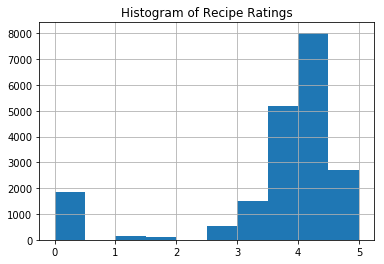

The median value for recipe rating is 4.375
There are 10738 observations below 4, and 9314 above or equal to it.


In [4]:
raw_data.rating.hist(bins=10)
plt.title('Histogram of Recipe Ratings')
plt.show()

proposed_cutoff = 4
below = raw_data['rating'][raw_data['rating'] >= proposed_cutoff].shape[0]
above = raw_data['rating'][raw_data['rating'] < 4].shape[0]

print('The median value for recipe rating is {}'.format(raw_data['rating'].median()))
print('There are {} observations below {}, and {} above or equal to it.'.format(below, proposed_cutoff, above))

###### I'm choosing 4 as the cut point for the binary rating variable. It's near the numeric center of the set, and it's my subjective opinion that a rating of 4 or above is "pretty good".

In [5]:
all_data = raw_data.copy()
all_data['rating_hilo'] = np.where(all_data['rating'] >= 4, 1, 0).astype(int)

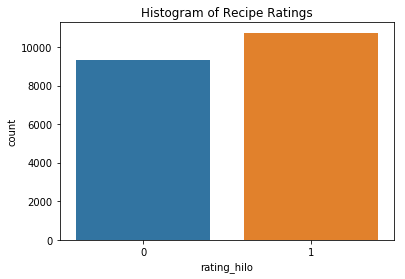

In [6]:
sns.countplot(x='rating_hilo', data=all_data)
plt.title('Histogram of Recipe Ratings')
plt.show()

## Dealing with nulls

###### I have two options here – I can either cut out the nulls in the nutrition data by dropping their rows (which will deprive our model of about a quarter of our observations), or by removing the nutritional information columns altogether (which will deprive our model of the 5 most interesting features). I have a hunch that the nutrition data is probably valuable, but I can check that assumption by running decision trees on both datasets (this data is small enough that they shouldn't take too long) and comparing performance.

In [7]:
# Drop the rows
rows_dropped = all_data.copy().drop(['rating','title'], axis=1).dropna(axis=0)
print('n with rows dropped: {}'.format(rows_dropped.shape[0]))

# Drop the columns
cols_dropped = all_data.copy().drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], axis=1)
print('n with columns dropped: {}'.format(cols_dropped.shape[0]))

n with rows dropped: 15864
n with columns dropped: 20052


###### With the rows dropped

In [8]:
# Define X & Y
rX = pd.DataFrame(rows_dropped.drop(['rating_hilo'], axis=1))
rY = rows_dropped['rating_hilo']

# Initialize and train the tree
row_rfc = RandomForestClassifier(max_features=30, criterion='entropy')
row_rfc.fit(rX, rY)
score = cross_val_score(row_rfc, rX, rY, cv=10)

In [9]:
# Cross validate
print('Decision tree model')
print('Mean accuracy across 10 folds: {}'.format(round(score.mean(),2)))
print('Variance: {}'.format(round(score.std()**2,4)))


print('\n** Rows dropped performance across 10 folds')
print(cross_validation(rows_dropped, row_rfc, 10, 'rating_hilo', list(rX)).describe().round(2)[['percent_mislabeled','sensitivity','specificity']][1:3])

Decision tree model
Mean accuracy across 10 folds: 0.63
Variance: 0.0001

** Rows dropped performance across 10 folds
      percent_mislabeled  sensitivity  specificity
mean                0.01        98.38        99.49
std                 0.00         0.31         0.24


###### With the columns dropped

In [10]:
cX = pd.DataFrame(cols_dropped.drop(['rating_hilo'], axis=1))
cY = cols_dropped['rating_hilo']

# Initialize and train our tree.
col_rfc = RandomForestClassifier(max_features=30, criterion='entropy')
col_rfc.fit(cX, cY)
score = cross_val_score(col_rfc, cX, cY, cv=10)

In [11]:
print('Mean accuracy across 10 folds: {}'.format(round(score.mean(),2)))
print('Variance: {}'.format(round(score.std()**2,4)))

print('\n** Columns dropped prediction performance across 10 folds')
print(cross_validation(cols_dropped, col_rfc, 10, 'rating_hilo', list(cX)).describe().round(2)[['percent_mislabeled','sensitivity','specificity']][1:3])

Mean accuracy across 10 folds: 0.63
Variance: 0.0002

** Columns dropped prediction performance across 10 folds
      percent_mislabeled  sensitivity  specificity
mean                0.01        98.08        99.34
std                 0.00         0.74         0.35


###### Those look nearly identical.  Let's have a closer look at feature importance between the two models to see how much the nutrition features are contributing.

In [12]:
rowdr_feature_importance = {'feature':list(rX),'feature_importance':list(row_rfc.feature_importances_)}     
rowdr_feature_importance = pd.DataFrame(rowdr_feature_importance)

print('Rows dropped model:')
rowdr_feature_importance[rowdr_feature_importance['feature_importance'] >= .01]

Rows dropped model:


,feature,feature_importance
0,calories,0.060640
1,protein,0.044627
2,fat,0.049180
3,sodium,0.060632


###### It looks as though the nutrition features are far and away the most important in this model. How does that compare with the importance of features in the columns dropped model?

In [13]:
coldr_feature_importance = {'feature':list(cX),'feature_importance':list(col_rfc.feature_importances_)}     
coldr_feature_importance = pd.DataFrame(coldr_feature_importance)

print('Columns dropped model:')
coldr_feature_importance[coldr_feature_importance['feature_importance'] >= .01]

Columns dropped model:


,feature,feature_importance
502,quick & easy,0.011354
597,summer,0.010624
661,winter,0.011185


###### The nutrition columns are more impactful than any other features in the dataset. Let's move forward with the model that retains them and drops null rows.

## First iteration

In [14]:
X = pd.DataFrame(rows_dropped[['calories', 'protein', 'fat', 'sodium']])
Y = rows_dropped['rating_hilo']

In [15]:
svr2 = SVR()
svr2.fit(X, Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [16]:
cross_val_score(svr2, X, Y, cv=5)

array([0.13313117, 0.10589892, 0.10130665, 0.11739195, 0.1192018 ])

###### This model still sucks! Maybe I should try a different feature selection method?

## Second iteration

The features my random forests chose didn't do me a lot of good. I'm going to make an attempt at feature selection via select K best.

In [42]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

selector = SelectKBest(chi2, k=30)
selector.fit(rX,rY)

rd_k_best = rows_dropped.copy()
idxs_selected = selector.get_support(indices=True)
best_30 = list(rd_k_best[rd_k_best.columns[idxs_selected]].head())

print('Best 30 Features:')
print(best_30)

Best 30 Features:
['calories', 'protein', 'fat', 'sodium', 'alcoholic', 'bitters', 'bon appétit', 'christmas', 'cocktail', 'cocktail party', 'dinner', 'drink', 'fall', 'gin', 'goat cheese', 'grill', 'grill/barbecue', 'harpercollins', 'house & garden', 'low carb', 'pasta', 'peanut free', 'quick & easy', 'roast', 'soy free', 'spirit', 'stuffing/dressing', 'thanksgiving', 'vegan', 'turkey']


In [43]:
X = pd.DataFrame(rows_dropped[best_30])
Y = rows_dropped['rating_hilo']

In [44]:
svr3 = SVR()
svr3.fit(X, Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [46]:
cross_val_score(svr3, X, Y, cv=5)

array([0.0740986 , 0.04969971, 0.06998488, 0.08906999, 0.08302533])

I got pretty good lift here overall, but the model is still overfit.

## Third iteration

In [50]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

selector = SelectKBest(chi2, k=10)
selector.fit(rX,rY)

rd_k_best = rows_dropped.copy()
idxs_selected = selector.get_support(indices=True)
best_10 = list(rd_k_best[rd_k_best.columns[idxs_selected]].head())

print('Best 30 Features:')
print(best_10)

Best 30 Features:
['calories', 'protein', 'fat', 'sodium', 'bon appétit', 'drink', 'gin', 'house & garden', 'roast', 'thanksgiving']


In [51]:
X = pd.DataFrame(rows_dropped[best_10])
Y = rows_dropped['rating_hilo']

In [52]:
svr4 = SVR()
svr4.fit(X, Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [53]:
cross_val_score(svr4, X, Y, cv=5)

array([0.11869094, 0.08882676, 0.09069588, 0.11076892, 0.11105956])

###### The second iteration is the best – less overfit than the third. 